- 전처리팁
    - 결측치확인, 분포확인, 통계량 확인
    - 분포에서 지나치게 극단값을 가지는 아웃라이어 확인
    - 데이터변형

- 다중회귀모델


아이디어
- 소셜 네트워크 광고인만큼 어떤 대상을 타겟으로 광고를 집중하는 것이 이득인지를 알아내는 것이 목적.
- 나이, 성별, 급여가 이들을 나눌 수 있는 그룹.- 독립변수로 생성
- 구매여부 - 종속변수
- 모델
    - 랜덤포레스트 분류
    - 다중회귀
    - 임금, 나이별 클러스터링
    - KNN
    - 생존분석

- 검증
    - 교차검증
    - shap


패키지

In [43]:
# 분석
import pandas as pd
import numpy as np
import scipy.stats as stats
import string
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import silhouette_score, adjusted_rand_score, v_measure_score

# 시각화
import seaborn as sns
import matplotlib.pyplot as plt


# 머신러닝 패키지
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
import shap
from sklearn.metrics import roc_curve, roc_auc_score
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA


shap.initjs()

데이터셋

In [2]:
df = pd.read_csv("./data/Social_Network_Ads.csv")
df

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0
...,...,...,...,...,...
395,15691863,Female,46,41000,1
396,15706071,Male,51,23000,1
397,15654296,Female,50,20000,1
398,15755018,Male,36,33000,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   User ID          400 non-null    int64 
 1   Gender           400 non-null    object
 2   Age              400 non-null    int64 
 3   EstimatedSalary  400 non-null    int64 
 4   Purchased        400 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 15.8+ KB


데이터탐색

In [4]:
df.isnull().sum()

User ID            0
Gender             0
Age                0
EstimatedSalary    0
Purchased          0
dtype: int64

In [5]:
df.duplicated().sum()

0

In [ ]:
df.describe().iloc[:, 1:]

In [ ]:
sorted(df["Age"].unique())

In [ ]:
df[df["Age"] == 19]

나이가 너무 적거나 급여가 너무 극단값에 있는 것은 이상치로 고려해볼 수 있지만 우선 진행

EDA

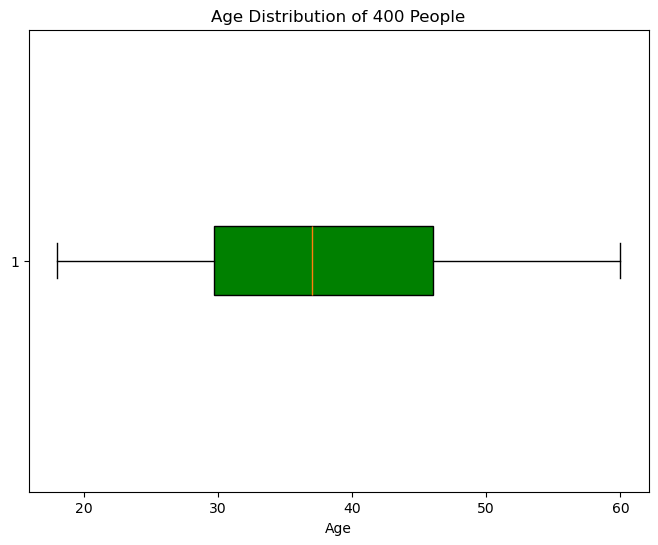

In [6]:
plt.figure(figsize=(8, 6))
plt.boxplot(df["Age"], vert=False, patch_artist=True, boxprops=dict(facecolor="green"))
plt.title("Age Distribution of 400 People")
plt.xlabel("Age")
plt.show()

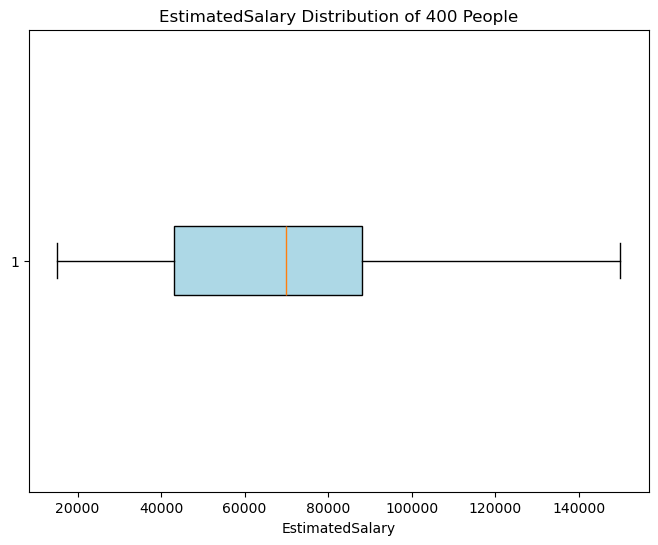

In [7]:
plt.figure(figsize=(8, 6))
plt.boxplot(
    df["EstimatedSalary"],
    vert=False,
    patch_artist=True,
    boxprops=dict(facecolor="lightblue"),
)
plt.title("EstimatedSalary Distribution of 400 People")
plt.xlabel("EstimatedSalary")
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))

sns.distplot(x=df["EstimatedSalary"])
plt.title("EstimatedSalary Distribution plot")
plt.xlabel("EstimatedSalary")

In [ ]:
plt.figure(figsize=(8, 6))

stats.probplot(df["EstimatedSalary"], dist="norm", plot=plt)
plt.title("QQ Plot EstimatedSalary Data")
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))

sns.distplot(x=df["Age"])
plt.title("Age Distribution plot")
plt.xlabel("Age")

In [ ]:
plt.figure(figsize=(8, 6))

stats.probplot(df["Age"], dist="norm", plot=plt)
plt.title("QQ Plot Age Data")
plt.show()

전처리

In [ ]:
df

성별은 string 타입임으로 레이블 인코더로 전처리

In [8]:
# encoding
encoder = LabelEncoder()
encoder.fit(df["Gender"])

# transform
df["Gender"] = encoder.transform(df["Gender"])

In [9]:
df["Gender"]

0      1
1      1
2      0
3      0
4      1
      ..
395    0
396    1
397    0
398    1
399    0
Name: Gender, Length: 400, dtype: int32

연령대를 구간으로 나눠 새로운 열 추가

In [10]:
df["Age_label"] = 0

In [11]:
df["Age_label"] = 0  # 초기화
df["Age_label"][df["Age"] >= 10] = 1
df["Age_label"][df["Age"] >= 20] = 2
df["Age_label"][df["Age"] >= 30] = 3
df["Age_label"][df["Age"] >= 40] = 4
df["Age_label"][df["Age"] >= 50] = 5

C:\Users\user\AppData\Local\Temp\ipykernel_456\2680884106.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df["Age_label"][df["Age"] >= 10] = 1
C:\Users\user\AppData\Local\Temp\ipykernel_456\2680884106.py:2: SettingWithCopyWarning: 
A val

In [12]:
df

,User ID,Gender,Age,EstimatedSalary,Purchased,Age_label
0,15624510,1,19,19000,0,1
1,15810944,1,35,20000,0,3
2,15668575,0,26,43000,0,2
3,15603246,0,27,57000,0,2
4,15804002,1,19,76000,0,1
...,...,...,...,...,...,...
395,15691863,0,46,41000,1,4
396,15706071,1,51,23000,1,5
397,15654296,0,50,20000,1,5
398,15755018,1,36,33000,0,3


In [13]:
age_salary_mean = df.groupby("Age_label")["EstimatedSalary"].mean()

# 결과 출력
print(age_salary_mean)

Age_label
1    54500.000000
2    60443.181818
3    73079.710145
4    70201.834862
5    79000.000000
Name: EstimatedSalary, dtype: float64


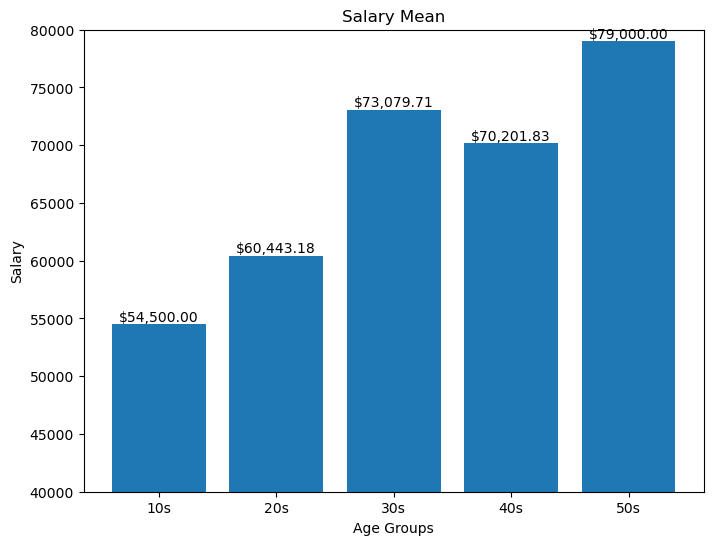

In [14]:
age_labels = ["10s", "20s", "30s", "40s", "50s"]
salary_means = [54500, 60443.18, 73079.71, 70201.83, 79000]

# Plotting
plt.figure(figsize=(8, 6))
bars = plt.bar(age_labels, salary_means)

# Add value labels on the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        yval,
        f"${yval:,.2f}",
        ha="center",
        va="bottom",
    )

# Adding dollar sign to the y-axis
# plt.gca().set_yticklabels(["${:,.0f}".format(x) for x in plt.gca().get_yticks()])

plt.title("Salary Mean")
plt.xlabel("Age Groups")
plt.ylabel("Salary")
plt.ylim(40000, 80000)
plt.show()

In [15]:
scaler = StandardScaler()
scaler.fit(df)
scaled = scaler.transform(df)

df_scaled = pd.DataFrame(data=scaled, columns=df.columns)
df_scaled

,User ID,Gender,Age,EstimatedSalary,Purchased,Age_label
0,-0.936579,1.020204,-1.781797,-1.490046,-0.745936,-2.176118
1,1.668387,1.020204,-0.253587,-1.460681,-0.745936,-0.248217
2,-0.320877,-0.980196,-1.113206,-0.785290,-0.745936,-1.212168
3,-1.233692,-0.980196,-1.017692,-0.374182,-0.745936,-1.212168
4,1.571389,1.020204,-1.781797,0.183751,-0.745936,-2.176118
...,...,...,...,...,...,...
395,0.004517,-0.980196,0.797057,-0.844019,1.340598,0.715733
396,0.203039,1.020204,1.274623,-1.372587,1.340598,1.679684
397,-0.520392,-0.980196,1.179110,-1.460681,1.340598,1.679684
398,0.886955,1.020204,-0.158074,-1.078938,-0.745936,-0.248217


In [ ]:
df

C:\Users\user\AppData\Local\Temp\ipykernel_456\1955396290.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x=df_scaled["EstimatedSalary"])


<Axes: ylabel='Density'>

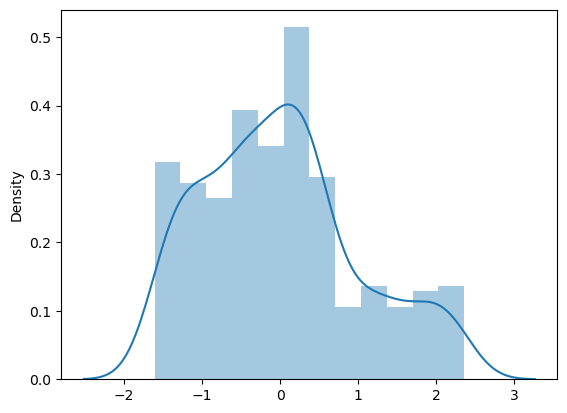

In [16]:
sns.distplot(x=df_scaled["EstimatedSalary"])

In [ ]:
sns.distplot(x=df_scaled["Age"])

In [ ]:
sns.distplot(x=df["Age_label"])

In [ ]:
plt.figure(figsize=(8, 6))

sns.regplot(data=df, x="Age", y="EstimatedSalary", marker="+")

plt.title("Regplot")

In [ ]:
df["Purchased"].value_counts()

In [ ]:
class_counts = [257, 143]
labels = ["Purchased = 0", "Purchased = 1"]

# 파이 차트 그리기
plt.figure(figsize=(8, 6))
plt.pie(
    class_counts,
    labels=labels,
    autopct="%1.1f%%",
    startangle=140,
    colors=["#66b3ff", "#ff9999"],
)

# 타이틀 설정
plt.title("Purchased Class Distribution")
plt.axis("equal")  # 원을 동그랗게 표시

# 그래프 표시
plt.show()

나이와 수입 사이의 상관분석

In [17]:
rho_t, p_val_t = stats.pearsonr(df["Age"], df["EstimatedSalary"])

print("correaltion coefficient : {}, p-value : {}".format(rho_t, p_val_t))

correaltion coefficient : 0.15523801797210007, p-value : 0.0018460568005798244


모델

In [ ]:
df_scaled.info()

In [18]:
X = df[["Gender", "Age", "EstimatedSalary"]]
y = df["Purchased"]

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=12345
)

분류모델

In [21]:
X_test

,Gender,Age,EstimatedSalary
378,1,41,87000
175,0,23,28000
396,1,51,23000
213,1,35,58000
110,0,39,71000
...,...,...,...
391,1,47,23000
246,0,35,50000
354,1,36,99000
358,1,40,71000


In [22]:
df_scaled

,User ID,Gender,Age,EstimatedSalary,Purchased,Age_label
0,-0.936579,1.020204,-1.781797,-1.490046,-0.745936,-2.176118
1,1.668387,1.020204,-0.253587,-1.460681,-0.745936,-0.248217
2,-0.320877,-0.980196,-1.113206,-0.785290,-0.745936,-1.212168
3,-1.233692,-0.980196,-1.017692,-0.374182,-0.745936,-1.212168
4,1.571389,1.020204,-1.781797,0.183751,-0.745936,-2.176118
...,...,...,...,...,...,...
395,0.004517,-0.980196,0.797057,-0.844019,1.340598,0.715733
396,0.203039,1.020204,1.274623,-1.372587,1.340598,1.679684
397,-0.520392,-0.980196,1.179110,-1.460681,1.340598,1.679684
398,0.886955,1.020204,-0.158074,-1.078938,-0.745936,-0.248217


In [71]:
df_scaled

,User ID,Gender,Age,EstimatedSalary,Purchased,Age_label,Cluster
0,-0.936579,1.020204,-1.781797,-1.490046,0,-2.176118,2
1,1.668387,1.020204,-0.253587,-1.460681,0,-0.248217,2
2,-0.320877,-0.980196,-1.113206,-0.785290,0,-1.212168,2
3,-1.233692,-0.980196,-1.017692,-0.374182,0,-1.212168,2
4,1.571389,1.020204,-1.781797,0.183751,0,-2.176118,2
...,...,...,...,...,...,...,...
395,0.004517,-0.980196,0.797057,-0.844019,1,0.715733,0
396,0.203039,1.020204,1.274623,-1.372587,1,1.679684,0
397,-0.520392,-0.980196,1.179110,-1.460681,1,1.679684,0
398,0.886955,1.020204,-0.158074,-1.078938,0,-0.248217,2


In [72]:
X = df_scaled[["Gender", "Age", "EstimatedSalary"]]  # 피처(입력 데이터)
y = df_scaled["Purchased"]  # 타겟(레이블)
y = (y > 0).astype(int)
df_scaled["Purchased"] = y
# 학습용 데이터와 테스트용 데이터로 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [24]:
rfc = RandomForestClassifier(n_estimators=1000, random_state=12345)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

In [25]:
print(rfc.score(X_train, y_train))
print(rfc.score(X_test, y_test))

0.996875
0.9


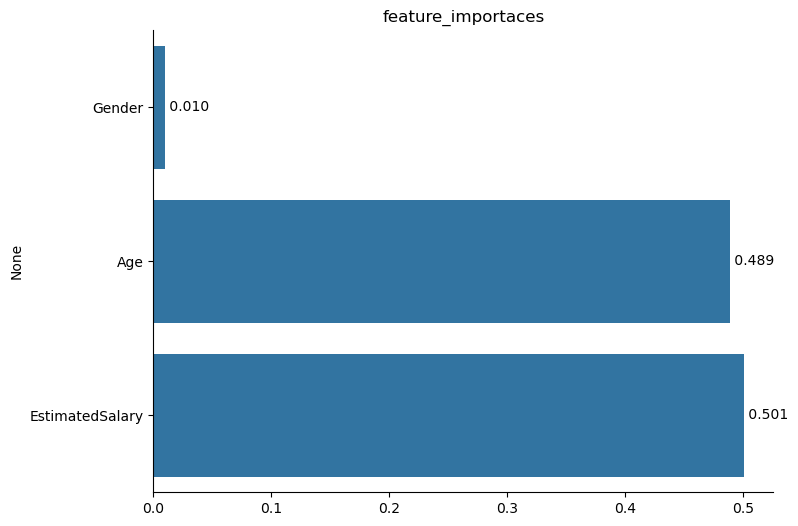

In [27]:
# feature_importance

plt.figure(figsize=(8, 6))
ax = sns.barplot(x=rfc.feature_importances_, y=X.columns)
ax.bar_label(ax.containers[0], fmt=" %.3f")
plt.gca().spines[["right", "top"]].set_visible(False)
plt.title("feature_importaces")
plt.show()

In [28]:
rfc.predict

<bound method ForestClassifier.predict of RandomForestClassifier(n_estimators=1000, random_state=12345)>

In [29]:
# shap

explainer = shap.KernelExplainer(rfc.predict, X_train)
explainer

Using 320 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [30]:
shap_train = explainer.shap_values(X_train)
shap_test = explainer.shap_values(X_test)

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

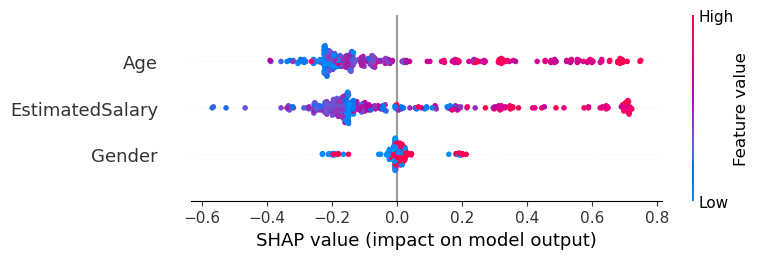

In [31]:
plt.figure(figsize=(8, 6))
shap.summary_plot(shap_train, X_train)

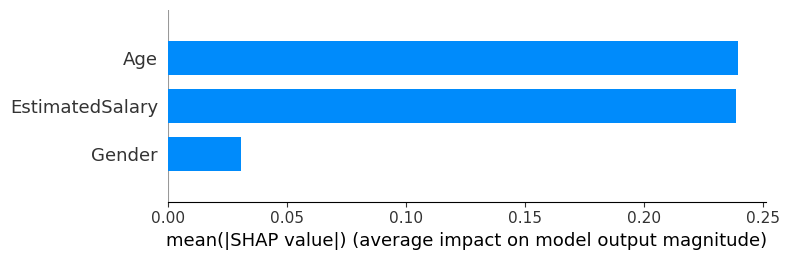

In [32]:
plt.figure(figsize=(8, 6))
shap.summary_plot(shap_train, X_train, plot_type="bar")

In [33]:
shap_value = explainer.shap_values(X_test)

  0%|          | 0/80 [00:00<?, ?it/s]

In [34]:
shap.force_plot(explainer.expected_value, shap_value, X_test)

In [ ]:
df

In [35]:
shap.force_plot(explainer.expected_value, shap_value[0], X_test.iloc[0], link="logit")

In [ ]:
y

In [ ]:
# train_index

In [ ]:
X.values

In [ ]:
# test_index

In [36]:
skfold = StratifiedKFold(n_splits=10, shuffle=False)
cv_index = skfold.split(X, y)

cv_accuracy = []
ind = 1

for train_index, test_index in cv_index:
    X_train, X_test = X.values[train_index], X.values[test_index]
    y_train, y_test = y[train_index], y[test_index]

    rfc.fit(X_train, y_train)
    accuracy = rfc.score(X_test, y_test)

    print(f"{ind}번째 Cross Validation 정확도: {accuracy:.2%}")
    cv_accuracy.append(accuracy)

    ind += 1

print(
    f"""-------------------------------------------
Cross Validation 정확도 평균: {np.mean(cv_accuracy):.2%}"""
)

1번째 Cross Validation 정확도: 97.50%
2번째 Cross Validation 정확도: 75.00%
3번째 Cross Validation 정확도: 90.00%
4번째 Cross Validation 정확도: 97.50%
5번째 Cross Validation 정확도: 97.50%
6번째 Cross Validation 정확도: 82.50%
7번째 Cross Validation 정확도: 82.50%
8번째 Cross Validation 정확도: 85.00%
9번째 Cross Validation 정확도: 82.50%
10번째 Cross Validation 정확도: 90.00%
-------------------------------------------
Cross Validation 정확도 평균: 88.00%


다중회귀

In [ ]:
df.columns

In [ ]:
sns.regplot(data=df, x="Age", y="EstimatedSalary", marker="+")

In [ ]:
sns.pairplot(df, kind="reg")
plt.show()

In [ ]:
df

In [37]:
X_train

array([[ 1.02020406, -1.78179743, -1.49004624],
       [ 1.02020406, -0.25358736, -1.46068138],
       [-0.98019606, -1.11320552, -0.78528968],
       ...,
       [ 1.02020406,  0.31949142,  0.50676401],
       [-0.98019606,  1.94321462, -1.37258681],
       [ 1.02020406,  0.98808332, -1.07893824]])

In [38]:
softmax_reg = LogisticRegression(random_state=12345)
softmax_reg.fit(X_train, y_train)

LogisticRegression(random_state=12345)

In [39]:
print(softmax_reg.score(X_train, y_train))
print(softmax_reg.score(X_test, y_test))

0.85
0.7


In [ ]:
explainer = shap.KernelExplainer(softmax_reg.predict, X_train)
explainer

In [ ]:
shap_train = explainer.shap_values(X_train)
shap_test = explainer.shap_values(X_test)

In [ ]:
plt.figure(figsize=(8, 6))

shap.summary_plot(shap_train, X_train)

In [ ]:
plt.figure(figsize=(8, 6))

shap.summary_plot(shap_train, X_train, plot_type="bar")

In [ ]:
skfold = StratifiedKFold(n_splits=10, shuffle=False)
cv_index = skfold.split(X, y)

cv_accuracy = []
ind = 1

for train_index, test_index in cv_index:
    X_train, X_test = X.values[train_index], X.values[test_index]
    y_train, y_test = y[train_index], y[test_index]

    softmax_reg.fit(X_train, y_train)
    accuracy = softmax_reg.score(X_test, y_test)

    print(f"{ind}번째 Cross Validation 정확도: {accuracy:.2%}")
    cv_accuracy.append(accuracy)

    ind += 1

print(
    f"""-------------------------------------------
Cross Validation 정확도 평균: {np.mean(cv_accuracy):.2%}"""
)

In [ ]:
y_probs = softmax_reg.predict_proba(X_test)[:, 1]  # 클래스 1에 대한 확률만 가져옵니다.

# ROC 곡선을 그리기 위해 fpr, tpr 값을 계산합니다.
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# ROC AUC 점수를 계산합니다.
roc_auc = roc_auc_score(y_test, y_probs)

# ROC 곡선을 그립니다.
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="red", linestyle="--")  # 대각선 기준선
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

In [ ]:
y_pred = softmax_reg.predict(X_test)
mat = metrics.confusion_matrix(y_test, y_pred)
mat_df = pd.DataFrame(
    mat,
    index=["Actual Negative", "Actual Positive"],
    columns=["Predicted Negative", "Predicted Positive"],
)
mat_df

클러스터링

In [ ]:
df_scaled

In [41]:
df

,User ID,Gender,Age,EstimatedSalary,Purchased,Age_label
0,15624510,1,19,19000,0,1
1,15810944,1,35,20000,0,3
2,15668575,0,26,43000,0,2
3,15603246,0,27,57000,0,2
4,15804002,1,19,76000,0,1
...,...,...,...,...,...,...
395,15691863,0,46,41000,1,4
396,15706071,1,51,23000,1,5
397,15654296,0,50,20000,1,5
398,15755018,1,36,33000,0,3


In [40]:
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)

y_pred = kmeans.fit_predict(X)

c:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# 클러스터링을 위한 피처 선택 (Age와 EstimatedSalary)
X = df[["Age", "EstimatedSalary"]]

# 엘보우 방법을 사용하여 적절한 클러스터 수를 찾습니다.
inertia = []
K = range(1, 10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# 엘보우 그래프를 그립니다.
plt.figure(figsize=(8, 6))
plt.plot(K, inertia, "bx-")

plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method For Optimal k")
plt.show()

In [ ]:
df

c:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\user\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


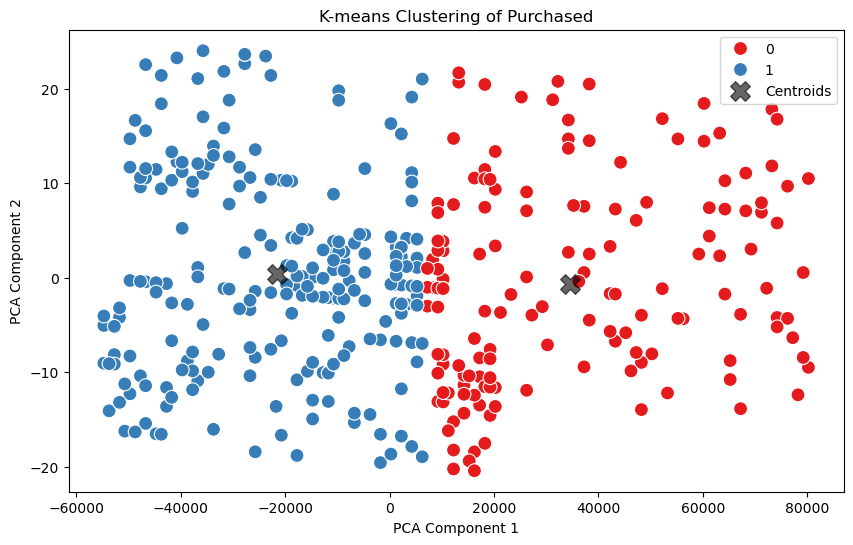

In [44]:
X = df[["Gender", "Age", "EstimatedSalary"]]

# Apply KMeans clustering
kmeans = KMeans(
    n_clusters=2, random_state=42
)  # Assuming 2 clusters for Purchased (0 or 1)
kmeans.fit(X)
df["Cluster"] = kmeans.labels_

# Use PCA for 2D visualization
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X)

# Visualization
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=pca_components[:, 0],
    y=pca_components[:, 1],
    hue=df["Cluster"],
    palette="Set1",
    s=100,
)

# Add cluster centers to the plot
centroids = kmeans.cluster_centers_
centroids_2d = pca.transform(centroids)
plt.scatter(
    centroids_2d[:, 0],
    centroids_2d[:, 1],
    c="black",
    s=200,
    alpha=0.6,
    marker="X",
    label="Centroids",
)

plt.title("K-means Clustering of Purchased")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()

c:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


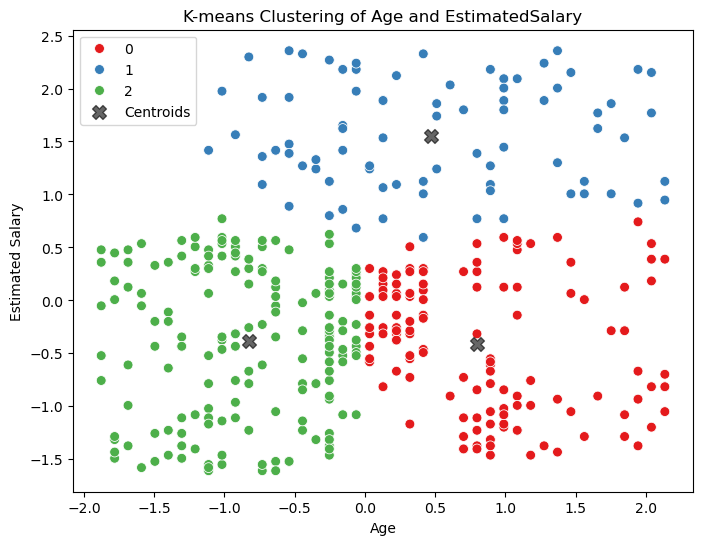

In [64]:
X = df_scaled[["Age", "EstimatedSalary"]]

# Apply KMeans clustering
kmeans = KMeans(
    n_clusters=3, random_state=42
)  # Assuming 2 clusters for Purchased (0 or 1)
kmeans.fit(X)
df_scaled["Cluster"] = kmeans.labels_

# Visualization
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=df_scaled["Age"],
    y=df_scaled["EstimatedSalary"],
    hue=df_scaled["Cluster"],
    palette="Set1",
    s=50,
)

# Add cluster centers to the plot
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    c="black",
    s=100,
    alpha=0.6,
    marker="X",
    label="Centroids",
)

plt.title("K-means Clustering of Age and EstimatedSalary")
plt.xlabel("Age")
plt.ylabel("Estimated Salary")
plt.legend()
plt.show()

In [66]:
df_scaled

,User ID,Gender,Age,EstimatedSalary,Purchased,Age_label,Cluster
0,-0.936579,1.020204,-1.781797,-1.490046,-0.745936,-2.176118,2
1,1.668387,1.020204,-0.253587,-1.460681,-0.745936,-0.248217,2
2,-0.320877,-0.980196,-1.113206,-0.785290,-0.745936,-1.212168,2
3,-1.233692,-0.980196,-1.017692,-0.374182,-0.745936,-1.212168,2
4,1.571389,1.020204,-1.781797,0.183751,-0.745936,-2.176118,2
...,...,...,...,...,...,...,...
395,0.004517,-0.980196,0.797057,-0.844019,1.340598,0.715733,0
396,0.203039,1.020204,1.274623,-1.372587,1.340598,1.679684,0
397,-0.520392,-0.980196,1.179110,-1.460681,1.340598,1.679684,0
398,0.886955,1.020204,-0.158074,-1.078938,-0.745936,-0.248217,2


Text(0.5, 1.0, 'Purchased')

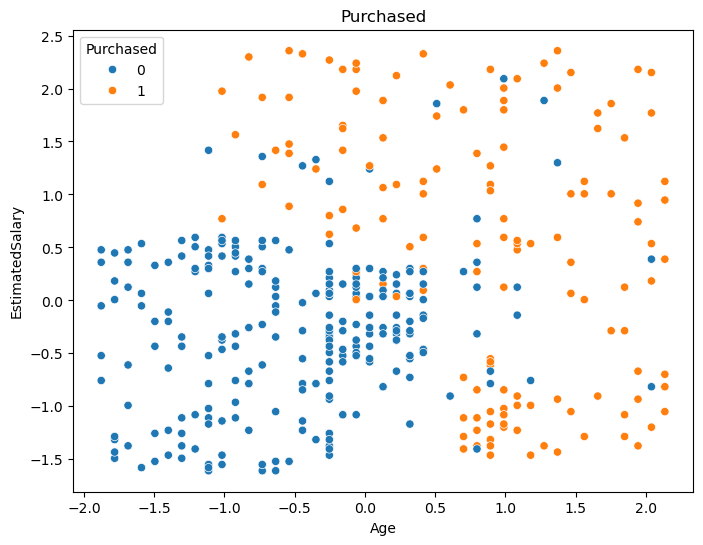

In [76]:
plt.figure(figsize=(8, 6))
sns.scatterplot(df_scaled, x="Age", y="EstimatedSalary", hue="Purchased")
plt.title("Purchased")

In [51]:
kmeans = KMeans(n_clusters=2, random_state=0)
y_pred = kmeans.fit_predict(X)

# 실루엣 점수 계산
silhouette_avg = silhouette_score(X, y_pred)
print(f"Silhouette Score: {silhouette_avg:.3f}")

c:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Silhouette Score: 0.383


c:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are les

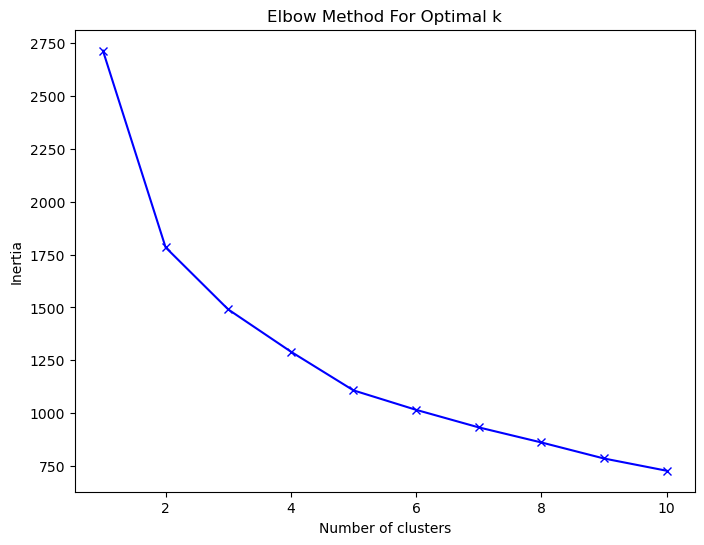

In [52]:
inertia = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)

# 엘보우 그래프 그리기
plt.figure(figsize=(8, 6))
plt.plot(K, inertia, "bx-")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method For Optimal k")
plt.show()

생존분석

In [ ]:
df

In [ ]:
df["Purchased"].value_counts()

In [ ]:
df["Purchased_bool"] = df["Purchased"].astype(bool)

In [ ]:
from lifelines import KaplanMeierFitter

T = df["Age"]  # 생존 시간 (여기서는 나이)
E = df["Purchased"]  # 이벤트 발생 여부 (구매 여부)

# Kaplan-Meier Fitter 사용
kmf = KaplanMeierFitter()

# 전체 데이터에 대해 생존 곡선 피팅
kmf.fit(T, event_observed=E)

# 생존 곡선 시각화
kmf.plot_survival_function()
plt.title("Survival Analysis: Age vs. Purchased")
plt.xlabel("Age")
plt.ylabel("Survival Probability")
plt.show()

In [ ]:
from lifelines import KaplanMeierFitter

T = df["EstimatedSalary"]  # 생존 시간 (여기서는 나이)
E = df["Purchased"]  # 이벤트 발생 여부 (구매 여부)

# Kaplan-Meier Fitter 사용
kmf = KaplanMeierFitter()

# 전체 데이터에 대해 생존 곡선 피팅
kmf.fit(T, event_observed=E)

# 생존 곡선 시각화
kmf.plot_survival_function()

plt.title("Survival Analysis: EstimatedSalary vs. Purchased")
plt.xlabel("EstimatedSalary")
plt.ylabel("Survival Probability")
plt.show()